In [1]:
import pandas as pd
from astropy.io import fits
import math
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from photutils.aperture import EllipticalAperture
import skimage.draw
from photutils.aperture import aperture_photometry
from photutils import CircularAnnulus
from astropy.stats import sigma_clip

/tmp/ipykernel_63/3644885464.py:11: DeprecationWarning: `photutils.CircularAnnulus` is a deprecated alias for `photutils.aperture.CircularAnnulus` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAnnulus` to silence this warning.
  from photutils import CircularAnnulus


In [2]:
os.chdir('/data/aai/scratch/jchan/denoise/PAUS/dinggetest/simulation/pn2v/src/pn2v')
from core import prediction
from unet import UNet
from core import utils
device=utils.getDevice()

CUDA available? True


In [3]:
path_model='/data/aai/scratch/jchan/denoise/PAUS/dinggetest/simulation/model saved/'
model=torch.load(path_model+"/best_conv_N2V_PAUdm.net")

/tmp/ipykernel_63/3163146522.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model=torch.load(path_model+"/best_conv_N2V_PAUdm.net")


In [4]:
def background_annulus(data, mask, aperture_x, aperture_y, r_in=30, r_out=45):
    """Measure background in an annulus."""
    
    masked_data = np.ma.array(data=data, mask=mask != 0)
    masked_data = masked_data.filled(fill_value=0)

    center = (aperture_x, aperture_y)
    annulus_apertures = CircularAnnulus(center, r_in=r_in, r_out=r_out)
    masks = annulus_apertures.to_mask(method='center')

    cutout_data = masks.cutout(masked_data)

    clip_annulus_array = sigma_clip(cutout_data[cutout_data != 0], sigma=3, maxiters=2)

    S = pd.Series()
    S['annulus_mean'] = np.ma.mean(clip_annulus_array)
    S['annulus_median'] = np.ma.median(clip_annulus_array)
    S['annulus_std'] = np.ma.std(clip_annulus_array)
    S['annulus_samples'] = np.ma.count(clip_annulus_array)

    return S

def flux_elliptical(image, mask, aperture_x, aperture_y, aperture_theta, aperture_a, aperture_b):
    """Measure the flux withing an elliptical aperture."""
    
    PIXEL_SCALE = 0.263
    theta = -aperture_theta * np.pi / 180.
    a = aperture_a / PIXEL_SCALE
    b = aperture_b / PIXEL_SCALE

    center = (aperture_x, aperture_y)
    source_aperture = EllipticalAperture(center, a, b, theta)

    xmask = mask != 0
    raw_flux = aperture_photometry(image, source_aperture, mask=xmask)
   
    S = pd.Series()
    S['raw_flux'] = float(raw_flux['aperture_sum'][0])
    S['area'] = source_aperture.area
    
    return S

def cal_calerror(sig_src,sig_zp,zp,f_src):
    sig_cal = np.sqrt(sig_src**2 * sig_zp**2 + sig_src**2 * zp**2 + sig_zp**2 * f_src**2)
    return sig_cal

def cal_fcal(f_src,zp):
    f_cal = f_src * zp
    return f_cal

def creat_stamps(image, sources):
    y = math.floor(sources['aperture_x'].values[0])
    x = math.floor(sources['aperture_y'].values[0])
    #y = math.floor(sources['aperture_x'])
    #x = math.floor(sources['aperture_y'])
    x_start = max((x - cutout_size), 0)
    x_end = min((x + cutout_size), image.shape[0])
    y_start = max((y - cutout_size), 0)
    y_end = min((y + cutout_size), image.shape[1])

    stamps = image[x_start:x_end, y_start:y_end]
    return stamps

def photometry_oneimage(image, mask, aperture_x, aperture_y, aperture_theta, aperture_a, aperture_b):
    
    S1 = background_annulus(image, mask, aperture_x, aperture_y)
    S2 = flux_elliptical(image, mask, aperture_x, aperture_y, aperture_theta, aperture_a, aperture_b)

    flux_obs = S2['raw_flux'] - S2['area'] * S1['annulus_mean']
    return flux_obs, S1['annulus_std']

def generate_mask(size_data, image):

    num_sample = int(size_data[0] * size_data[1] * (1 - ratio))
    mask = np.ones(size_data)
    output = image

    for ich in range(size_data[2]):
        idy_msk = np.random.randint(0, size_data[0], num_sample)
        idx_msk = np.random.randint(0, size_data[1], num_sample)

        idy_neigh = np.random.randint(-size_window[0] // 2 + size_window[0] % 2, size_window[0] // 2 + size_window[0] % 2, num_sample)
        idx_neigh = np.random.randint(-size_window[1] // 2 + size_window[1] % 2, size_window[1] // 2 + size_window[1] % 2, num_sample)

        idy_msk_neigh = idy_msk + idy_neigh
        idx_msk_neigh = idx_msk + idx_neigh

        idy_msk_neigh = idy_msk_neigh + (idy_msk_neigh < 0) * size_data[0] - (idy_msk_neigh >= size_data[0]) * size_data[0]
        idx_msk_neigh = idx_msk_neigh + (idx_msk_neigh < 0) * size_data[1] - (idx_msk_neigh >= size_data[1]) * size_data[1]

        id_msk = (idy_msk, idx_msk, ich)
        id_msk_neigh = (idy_msk_neigh, idx_msk_neigh, ich)

        output[id_msk] = image[id_msk_neigh]
        mask[id_msk] = 0.0

    return output, mask

In [5]:
combined_NB705 = pd.read_csv('/data/aai/scratch/jchan/denoise/PAUS/output_save/denoisedgalaxyafter4.csv')
combined_NB705 = combined_NB705[(combined_NB705['I_auto']<19) & (combined_NB705['I_auto']>18)]
combined_NB705 = combined_NB705.reset_index(drop=True)

(-0.5, 95.5, 95.5, -0.5)

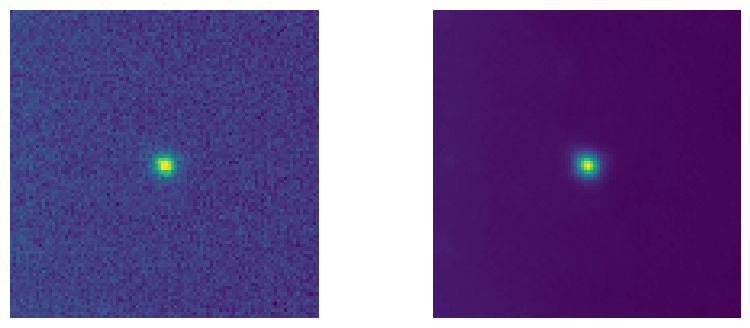

In [6]:
num = 150
row = combined_NB705.iloc[[num]]
path = combined_NB705['path'][num]
image = fits.getdata(path)
mask_cutout = fits.getdata(path.replace('.fits', '.mask.fits'))

cutout_size = 48
stamp_image = creat_stamps(image, row)
mask_cutout = creat_stamps(mask_cutout, row)

n2vResult = prediction.tiledPredict(stamp_image, model, ps=96, overlap=48,
                                            device=device, noiseModel=None)
fig, axes = plt.subplots(ncols=2,figsize=(10, 4))

im1 = axes[0].imshow(stamp_image)
axes[0].axis('off')

im2 = axes[1].imshow(n2vResult)
axes[1].axis('off')

In [7]:
image_shape = (96, 96)
PIXEL_SCALE = 0.263
per = 1#0.625

semi_major_axis = row['aperture_a'].item() * per / PIXEL_SCALE
semi_minor_axis = row['aperture_b'].item() * per / PIXEL_SCALE
rotation_angle = row['aperture_theta'].item()
theta = -rotation_angle * np.pi / 180.

aperture_x = cutout_size + row['aperture_x'].item() - math.floor(row['aperture_x'].item())
aperture_y = cutout_size + row['aperture_y'].item() - math.floor(row['aperture_y'].item())
center_coords = (aperture_x, aperture_y)

In [8]:
aper = EllipticalAperture(center_coords, semi_major_axis, semi_minor_axis, theta=theta)
mask_object = aper.to_mask(method='exact')
mask_image_photutils_fractional = mask_object.to_image(shape=image_shape)
#mask_image_photutils_boolean = mask_image_photutils_fractional.astype(bool) #this method create a bool mask

Text(0.5, 1.0, 'Mask')

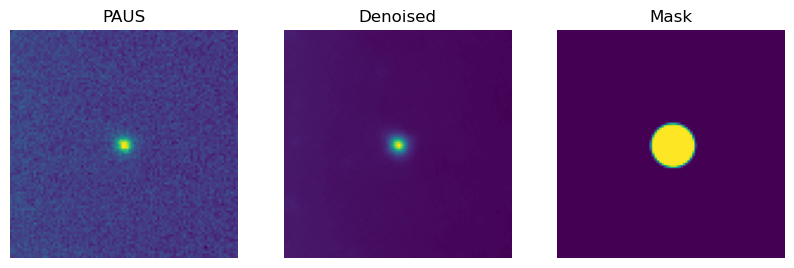

In [9]:
fig, axes = plt.subplots(ncols=3,figsize=(10, 4))

im1 = axes[0].imshow(stamp_image)
axes[0].axis('off')
axes[0].set_title('PAUS')

im2 = axes[1].imshow(n2vResult)
axes[1].axis('off')
axes[1].set_title('Denoised')

im3 = axes[2].imshow(mask_image_photutils_fractional)
axes[2].axis('off')
axes[2].set_title('Mask')

In [10]:
raw_flux = aperture_photometry(stamp_image, aper)
flux_weighted = np.sum(stamp_image * mask_image_photutils_fractional)#calculate by myself

background = background_annulus(stamp_image, mask_cutout, aperture_x, aperture_y)
galaxy_flux = flux_weighted - aper.area * background['annulus_mean']

#the raw flux in the galaxy area, the result I calcuated by myself and the one from 'aperture_photometry'
print(flux_weighted)
print(float(raw_flux['aperture_sum'][0]))
#compare the area I calculated with the apertures and the one from PAUS dataset
print(aper.area)
print(row['area'].item())
#compare the mean background flux 
print(row['annulus_mean'].item())
print(background['annulus_mean'])

733.0400524084434
733.0400524084437
270.92282211582466
270.92282211582466
2.1293044576364304
2.1293044576364304


In [11]:
row.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 150 to 150
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1 non-null      int64  
 1   annulus_mean       1 non-null      float64
 2   annulus_median     1 non-null      float64
 3   annulus_std        1 non-null      float64
 4   area               1 non-null      float64
 5   flux_obs           1 non-null      float64
 6   image_id           1 non-null      int64  
 7   ref_id             1 non-null      int64  
 8   filter             1 non-null      object 
 9   I_auto             1 non-null      float64
 10  zp                 1 non-null      float64
 11  zp_error           1 non-null      float64
 12  flux_error         1 non-null      float64
 13  aperture_x         1 non-null      float64
 14  aperture_y         1 non-null      float64
 15  aperture_theta     1 non-null      float64
 16  aperture_a         1 non-null  